# LSTM

In [7]:
# Imports
import pickle
import time
import os

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import keras
import tensorflow as tf

from utils import dataset
from utils.dataset import X, Y

tf.config.list_logical_devices(device_type=None)

2024-06-21 13:53:11.971724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 13:53:11.971807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 13:53:12.047239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-21 13:53:12.183555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 13:53:13.700545: W tensorflow/compiler/tf2

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

L344-L355
2024-06-21 13:53:18.317982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-21 13:53:18.318193: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-21 13:53:18.318331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14001 MB memory:  -> device: 0, name: Quadro RTX 5000 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


In [8]:
max_length = max(x.shape[0] for x in X)
X = [keras.preprocessing.sequence.pad_sequences(x.T, maxlen=max_length, padding="post", dtype="float64").T for x in X]
X = np.stack(X, axis=0)
Y = [keras.preprocessing.sequence.pad_sequences(y.T, maxlen=max_length, padding="post", dtype="float64").T for y in Y]
Y = np.stack(Y, axis=0)

times = []

kfold = KFold(n_splits=5)
train_index, test_index = kfold.split(X, Y).__next__()

X_train = tf.convert_to_tensor([X[i] for i in train_index])
Y_train = tf.convert_to_tensor([Y[i] for i in train_index])
X_test = tf.convert_to_tensor([X[i] for i in test_index])
Y_test = tf.convert_to_tensor([Y[i] for i in test_index])
    

## Time and performance vs size of the model

$$4 \times (7 \times n + n^2 + n) + 5 \times (n+1)$$

In [2]:
def number_of_params(n):
    return 4*n*(8+n)+5*(n+1)

### First instances

In [5]:
ns = list(range(10, 80, 14))

In [4]:
def lstm(n):
    print("# neurons: ", n)
    print("# trainable parameters: ", number_of_params(n))
    seed = 2504+n

    keras.utils.set_random_seed(seed)

    start = time.time()

    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=20)

    model = keras.Sequential()
    model.add(keras.layers.LSTM(n, return_sequences=True))
    model.add(keras.layers.Dense(5))
    model.compile(loss="mse", optimizer="adam")

    out = model.fit(
        X[train_index],
        Y[train_index],
        epochs=3000,
        callbacks=[callback],
        validation_data=(X[test_index], Y[test_index]),
        shuffle=True,
    )
    stop = time.time()

    with open(f"./models/lstm_seed={seed}_neurons={n}.pickle", "wb+") as file:
        pickle.dump(model, file)

    with open(f"./models/out_seed={seed}_neurons={n}.pickle", "wb+") as file:
        pickle.dump(out, file)

    times.append(stop - start)
    print(stop - start)

In [8]:
n = ns[0]

lstm(n)

# neurons:  10
# trainable parameters:  775
Epoch 1/3000


2024-06-15 14:50:01.010083: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-15 14:50:02.451725: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5574125740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-15 14:50:02.451756: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000 with Max-Q Design, Compute Capability 7.5
2024-06-15 14:50:02.473307: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718455802.646579    3850 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 9s 9s/step - loss: 0.1448 - val_loss: 0.1465
Epoch 2/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1417 - val_loss: 0.1434
Epoch 3/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1388 - val_loss: 0.1404
Epoch 4/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1359 - val_loss: 0.1376
Epoch 5/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1331 - val_loss: 0.1348
Epoch 6/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1305 - val_loss: 0.1322
Epoch 7/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1279 - val_loss: 0.1297
Epoch 8/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1255 - val_loss: 0.1272
Epoch 9/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1231 - val_loss: 0.1249
Epoch 10/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1209 - val_loss: 0.1226
Epoch 11/3000
1/1 [=======================

In [9]:
n = ns[1]

lstm(n)

# neurons:  24
# trainable parameters:  3197
Epoch 1/3000
1/1 [==============================] - 5s 5s/step - loss: 0.1122 - val_loss: 0.1047
Epoch 2/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1072 - val_loss: 0.1006
Epoch 3/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1024 - val_loss: 0.0968
Epoch 4/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0980 - val_loss: 0.0932
Epoch 5/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0938 - val_loss: 0.0898
Epoch 6/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0900 - val_loss: 0.0866
Epoch 7/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0864 - val_loss: 0.0836
Epoch 8/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0830 - val_loss: 0.0808
Epoch 9/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0799 - val_loss: 0.0781
Epoch 10/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0770 - v

In [10]:
n = ns[2]

lstm(n)

# neurons:  38
# trainable parameters:  7187
Epoch 1/3000
1/1 [==============================] - 5s 5s/step - loss: 0.0931 - val_loss: 0.0961
Epoch 2/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0882 - val_loss: 0.0909
Epoch 3/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0836 - val_loss: 0.0861
Epoch 4/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0793 - val_loss: 0.0816
Epoch 5/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0754 - val_loss: 0.0775
Epoch 6/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0717 - val_loss: 0.0738
Epoch 7/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0684 - val_loss: 0.0703
Epoch 8/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0653 - val_loss: 0.0672
Epoch 9/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0625 - val_loss: 0.0643
Epoch 10/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0599 - v

In [11]:
n = ns[3]

lstm(n)

# neurons:  52
# trainable parameters:  12745
Epoch 1/3000
1/1 [==============================] - 5s 5s/step - loss: 0.0926 - val_loss: 0.0841
Epoch 2/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0867 - val_loss: 0.0788
Epoch 3/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0813 - val_loss: 0.0739
Epoch 4/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0764 - val_loss: 0.0695
Epoch 5/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0719 - val_loss: 0.0654
Epoch 6/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0678 - val_loss: 0.0617
Epoch 7/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0640 - val_loss: 0.0583
Epoch 8/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0606 - val_loss: 0.0552
Epoch 9/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0575 - val_loss: 0.0524
Epoch 10/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0547 - 

In [12]:
n = ns[4]

lstm(n)

# neurons:  66
# trainable parameters:  19871
Epoch 1/3000
1/1 [==============================] - 5s 5s/step - loss: 0.1462 - val_loss: 0.1324
Epoch 2/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1319 - val_loss: 0.1198
Epoch 3/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1191 - val_loss: 0.1085
Epoch 4/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1077 - val_loss: 0.0983
Epoch 5/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0974 - val_loss: 0.0892
Epoch 6/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0881 - val_loss: 0.0811
Epoch 7/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0799 - val_loss: 0.0738
Epoch 8/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0726 - val_loss: 0.0674
Epoch 9/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0661 - val_loss: 0.0619
Epoch 10/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0604 - 

In [12]:
n = 150

lstm(n)

# neurons:  150
# trainable parameters:  95555
Epoch 1/3000
1/1 [==============================] - 6s 6s/step - loss: 0.0995 - val_loss: 0.0772
Epoch 2/3000
1/1 [==============================] - 4s 4s/step - loss: 0.0823 - val_loss: 0.0641
Epoch 3/3000
1/1 [==============================] - 4s 4s/step - loss: 0.0680 - val_loss: 0.0535
Epoch 4/3000
1/1 [==============================] - 4s 4s/step - loss: 0.0563 - val_loss: 0.0454
Epoch 5/3000
1/1 [==============================] - 4s 4s/step - loss: 0.0470 - val_loss: 0.0397
Epoch 6/3000
1/1 [==============================] - 4s 4s/step - loss: 0.0401 - val_loss: 0.0367
Epoch 7/3000
1/1 [==============================] - 4s 4s/step - loss: 0.0360 - val_loss: 0.0365
Epoch 8/3000
1/1 [==============================] - 4s 4s/step - loss: 0.0348 - val_loss: 0.0380
Epoch 9/3000
1/1 [==============================] - 4s 4s/step - loss: 0.0356 - val_loss: 0.0387
Epoch 10/3000
1/1 [==============================] - 4s 4s/step - loss: 0.0359 -

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [14]:
n = 250

lstm(n)

# neurons:  250
# trainable parameters:  259255
Epoch 1/3000
1/1 [==============================] - 8s 8s/step - loss: 0.0907 - val_loss: 0.0646
Epoch 2/3000
1/1 [==============================] - 6s 6s/step - loss: 0.0666 - val_loss: 0.0486
Epoch 3/3000
1/1 [==============================] - 6s 6s/step - loss: 0.0492 - val_loss: 0.0395
Epoch 4/3000
1/1 [==============================] - 5s 5s/step - loss: 0.0383 - val_loss: 0.0379
Epoch 5/3000
1/1 [==============================] - 6s 6s/step - loss: 0.0350 - val_loss: 0.0406
Epoch 6/3000
1/1 [==============================] - 5s 5s/step - loss: 0.0372 - val_loss: 0.0401
Epoch 7/3000
1/1 [==============================] - 5s 5s/step - loss: 0.0371 - val_loss: 0.0369
Epoch 8/3000
1/1 [==============================] - 6s 6s/step - loss: 0.0343 - val_loss: 0.0342
Epoch 9/3000
1/1 [==============================] - 5s 5s/step - loss: 0.0318 - val_loss: 0.0329
Epoch 10/3000
1/1 [==============================] - 5s 5s/step - loss: 0.0307 

In [7]:
n = 300

lstm(n)

# neurons:  300
# trainable parameters:  371105
Epoch 1/3000


2024-06-17 13:07:18.802723: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-17 13:07:21.422341: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f077c0b76d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-17 13:07:21.422374: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000 with Max-Q Design, Compute Capability 7.5
2024-06-17 13:07:21.439889: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718622441.594264   29473 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 12s 12s/step - loss: 0.1049 - val_loss: 0.0735
Epoch 2/3000
1/1 [==============================] - 6s 6s/step - loss: 0.0749 - val_loss: 0.0532
Epoch 3/3000
1/1 [==============================] - 7s 7s/step - loss: 0.0540 - val_loss: 0.0408
Epoch 4/3000
1/1 [==============================] - 7s 7s/step - loss: 0.0406 - val_loss: 0.0368
Epoch 5/3000
1/1 [==============================] - 7s 7s/step - loss: 0.0355 - val_loss: 0.0403
Epoch 6/3000
1/1 [==============================] - 7s 7s/step - loss: 0.0378 - val_loss: 0.0403
Epoch 7/3000
1/1 [==============================] - 7s 7s/step - loss: 0.0377 - val_loss: 0.0365
Epoch 8/3000
1/1 [==============================] - 7s 7s/step - loss: 0.0343 - val_loss: 0.0339
Epoch 9/3000
1/1 [==============================] - 7s 7s/step - loss: 0.0321 - val_loss: 0.0328
Epoch 10/3000
1/1 [==============================] - 7s 7s/step - loss: 0.0313 - val_loss: 0.0326
Epoch 11/3000
1/1 [=====================

In [ ]:
ns2 = [10, 24, 38, 52, 66, 150, 250, 300]
times = np.array([
    6007.741263628006,
    3291.594877243042,
    2883.320460796356,
    1914.39235329628,
    1659.7750256061554,
    3085.1975818387481,
    3046.1743454933167,
    4056.7037949562073,
]) / 60.

In [ ]:
ns = [10, 24, 38, 52, 66, 150, 250, 300, ]

times = np.array([
    6007.741263628006,
    3291.594877243042,
    2883.320460796356,
    1914.39235329628,
    1659.7750256061554,
    3085.1975818387481,
    3046.1743454933167,
    4056.7037949562073,
]) / 60.

scores = []
for n in ns:
    path = f"./models/out_seed={2504+n}_neurons={n}.pickle"
    with open(path, "rb") as file:
        res = pickle.load(file)
        scores.append(res.history["val_loss"][-1])

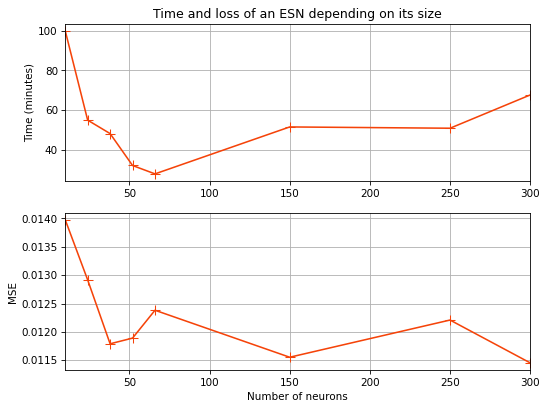

In [17]:
plt.figure(figsize=(8, 6))

plt.subplot(2,1,1)
plt.grid()
plt.plot(ns, times, "-+", markersize=10)
plt.title("Time and loss of an ESN depending on its size")
plt.ylabel("Time (minutes)")

plt.subplot(2,1,2)
plt.grid()
plt.plot(ns, scores, "-+", markersize=10)
plt.xlabel("Number of neurons")
plt.ylabel("MSE")

plt.show()

### More instances (regularly spaced between 30 and 300 neurons)

In [5]:
# redefine with another seed
def lstm(n):
    print("# neurons: ", n)
    print("# trainable parameters: ", number_of_params(n))
    seed = 260_418+n

    keras.utils.set_random_seed(seed)

    start = time.time()

    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=20)

    model = keras.Sequential()
    model.add(keras.layers.LSTM(n, return_sequences=True))
    model.add(keras.layers.Dense(5))
    model.compile(loss="mse", optimizer="adam")

    out = model.fit(
        X[train_index],
        Y[train_index],
        epochs=3000,
        callbacks=[callback],
        validation_data=(X[test_index], Y[test_index]),
        shuffle=True,
    )
    stop = time.time()

    with open(f"./models/lstm_seed={seed}_neurons={n}.pickle", "wb+") as file:
        pickle.dump(model, file)

    with open(f"./models/out_seed={seed}_neurons={n}.pickle", "wb+") as file:
        pickle.dump(out, file)

    times.append(stop - start)
    print(stop - start)

In [7]:
for n in range(30, 300, 30):
    lstm(n)

# neurons:  30
# trainable parameters:  4715
Epoch 1/3000


2024-06-19 20:29:36.515148: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-19 20:29:37.980705: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fccf007a1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-19 20:29:37.980734: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000 with Max-Q Design, Compute Capability 7.5
2024-06-19 20:29:37.997469: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718821778.149767    3340 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 9s 9s/step - loss: 0.1066 - val_loss: 0.1055
Epoch 2/3000
1/1 [==============================] - 2s 2s/step - loss: 0.1007 - val_loss: 0.0996
Epoch 3/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0953 - val_loss: 0.0941
Epoch 4/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0902 - val_loss: 0.0890
Epoch 5/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0854 - val_loss: 0.0842
Epoch 6/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0809 - val_loss: 0.0798
Epoch 7/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0768 - val_loss: 0.0757
Epoch 8/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0729 - val_loss: 0.0719
Epoch 9/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0693 - val_loss: 0.0684
Epoch 10/3000
1/1 [==============================] - 2s 2s/step - loss: 0.0660 - val_loss: 0.0652
Epoch 11/3000
1/1 [=======================

In [11]:
print(times)

[4025.4732117652893, 2097.4569003582, 2175.844747543335, 2057.3399698734283, 2635.9445605278015, 2007.5307533740997, 2139.294063806534, 2233.2337975502014, 3680.569529056549]


### Final plots

In [26]:
import glob
import re

neurons = []
scores = []


for path in glob.glob("./models/out_seed=*_neurons=*.pickle"):
    seed, neurons_ = re.fullmatch(r"\./models/out_seed=(\d+)_neurons=(\d+).pickle", path).groups()
    neurons.append(int(neurons_))

    with open(path, "rb") as file:
        res = pickle.load(file)
        scores.append(res.history["val_loss"][-1])

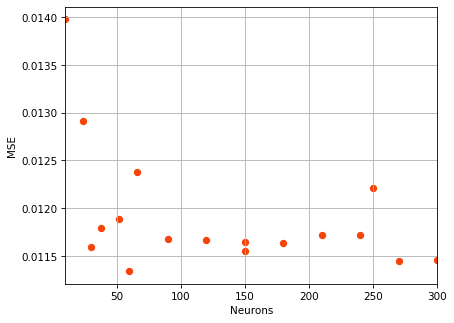

In [28]:
plt.figure()
plt.scatter(x=neurons, y=scores, )
plt.xlabel("Neurons")
plt.ylabel("MSE")
plt.grid()
plt.show()

[ 10  24  38  52  66 150 250 300  30  60  90 120 150 180 210 240 270] [100.12902106  54.85991462  48.05534101  31.90653922  27.66291709
  51.4199597   50.76957242  67.61172992  67.0912202   34.95761501
  36.26407913  34.2889995   43.93240934  33.45884589  35.65490106
  37.22056329  61.34282548]


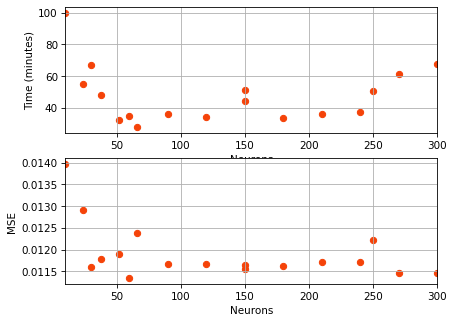

In [31]:
# Time
ns1 = [10, 24, 38, 52, 66, 150, 250, 300, ]

times1 = np.array([
    6007.741263628006,
    3291.594877243042,
    2883.320460796356,
    1914.39235329628,
    1659.7750256061554,
    3085.1975818387481,
    3046.1743454933167,
    4056.7037949562073,
]) / 60.

ns2 = list(range(30, 300, 30))
times2 = np.array([
    4025.4732117652893, 
    2097.4569003582, 
    2175.844747543335, 
    2057.3399698734283, 
    2635.9445605278015, 
    2007.5307533740997, 
    2139.294063806534, 
    2233.2337975502014, 
    3680.569529056549
]) / 60.

ns = np.concatenate((ns1, ns2))
times = np.concatenate((times1, times2))

print(ns, times)

plt.figure()
plt.subplot(2,1,1)
plt.scatter(x=ns, y=times, )
plt.xlabel("Neurons")
plt.ylabel("Time (minutes)")
plt.grid()
plt.subplot(2,1,2)
plt.scatter(x=neurons, y=scores, )
plt.xlabel("Neurons")
plt.ylabel("MSE")
plt.grid()
plt.show()

## Reach metrics

In [23]:
from utils import metrics

def get_model(n):

    if os.path.exists(f"./models/lstm_seed={2504+n}_neurons={n}.pickle"):
        print(2504)
        with open(f"./models/lstm_seed={2504+n}_neurons={n}.pickle", "rb") as file:
            model = pickle.load(file)
    elif os.path.exists(f"./models/lstm_seed={260_418+n}_neurons={n}.pickle"):
        print(260_418)
        with open(f"./models/lstm_seed={260_418+n}_neurons={n}.pickle", "rb") as file:
            model = pickle.load(file)
    else:
        raise ChildProcessError

    return model

_ = get_model(30)

260418


In [13]:
model60 = get_model(60)

Y_pred = model60.call(X_test)

260418


2024-06-21 13:57:34.676605: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


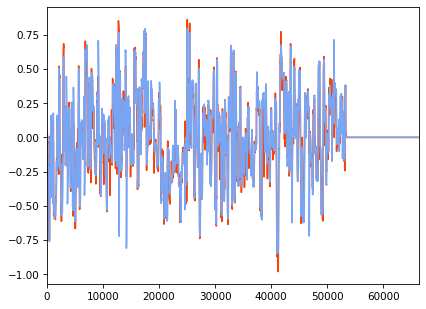

In [21]:
plt.figure()
plt.plot(Y_pred[0, :, 0])
plt.plot(Y_test[0, :, 0])
plt.show()

In [40]:
lengths = [dataset.Y[i].shape[0] for i in test_index]
Y_pred = [np.array(y_pred[:length]) for y_pred, length in zip(Y_pred, lengths)]

fold = dataset.kfold_infos().__next__()
X_train, Y_train, Info_train, X_test, Y_test, Info_test = fold

In [41]:
Y_pred_[0].shape

(53277, 5)

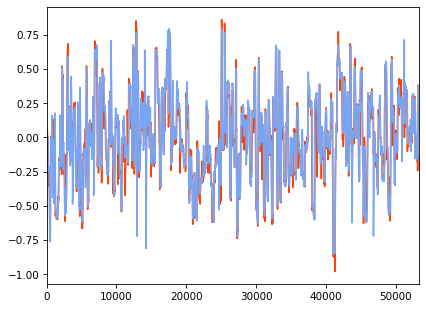

In [37]:
plt.figure()
plt.plot(Y_pred_[0][:, 0])
plt.plot(Y_test_[0][:, 0])
plt.show()

In [42]:
fold = dataset.kfold_infos().__next__()
_, _, _, _, _, Info_test = fold

lsd = metrics.last_step_distances(X_test, Y_pred_, Info_test)
lsd2 = metrics.last_step_distances(X_test, Y_test_, Info_test)
print(lsd[0].shape)
print(lsd2[0].shape)

(243,)
(243,)


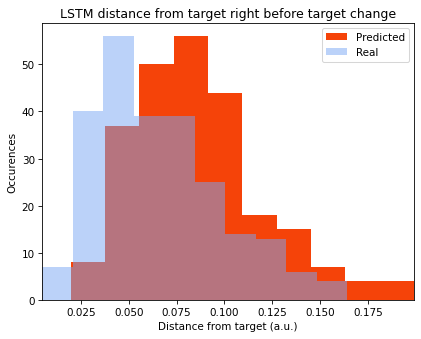

In [47]:
plt.figure()
plt.hist(lsd[0], label="Predicted")
plt.hist(lsd2[0], label="Real", alpha=0.5)
plt.xlabel("Distance from target (a.u.)")
plt.ylabel("Occurences")
plt.title("LSTM distance from target right before target change")
plt.legend()
plt.show()

In [44]:
rd = metrics.red_distances(X_test, Y_pred, Info_test)
rd2 = metrics.red_distances(X_test, Y_test, Info_test)
print(rd[0].shape)
print(rd2[0].shape)

(8513,)
(8513,)


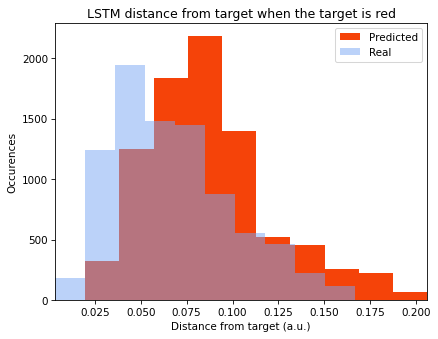

In [46]:
plt.figure()
plt.hist(rd[0], label="Predicted")
plt.hist(rd2[0], label="Real", alpha=0.5)
plt.xlabel("Distance from target (a.u.)")
plt.ylabel("Occurences")
plt.title("LSTM distance from target when the target is red")
plt.legend()
plt.show()